In [2]:
import os
import random
from glob import glob
import pandas as pd
import numpy as np
import torch
import timm
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import random_split
from torch import nn, optim
from torch.nn import functional as F
from torchvision import transforms
import matplotlib.pyplot as plt
from math import ceil
from tqdm.notebook import tqdm
import wandb
from torch_lr_finder import LRFinder
from utils import EarlyStopping
import utils
import plotly.express as px
from albumentations.augmentations.crops.functional import random_crop as functional_random_crop

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xfc in position 5: invalid start byte

In [ ]:
from scipy import ndimage
from pickle import load

In [ ]:
run = wandb.init(project='HyperView-initial', reinit=True)
# wandb.init(mode="disabled") # in case of testing code

### Paths definition

In [4]:
train_data_directory = r'../../train_data'
test_data_directory = r'../../test_data'
saved_models_directory = r'../../saved_models'
submissions_directory = r'../../submissions'

### Load mean and std values of training dataset

In [5]:
means_stds_arrays = np.load(os.path.join(
    train_data_directory, 'means_stds_values_training_data.npz'))
means = np.array(means_stds_arrays['means'])
stds = np.array(means_stds_arrays['stds'])

### Load scalers for parameters

In [6]:
parameters_scalers = dict()
parameters_scalers['P'] = load((open(os.path.join(train_data_directory, 'standard_scaler_P.pkl'), 'rb')))
parameters_scalers['K'] = load((open(os.path.join(train_data_directory, 'standard_scaler_K.pkl'), 'rb')))
parameters_scalers['Mg'] = load((open(os.path.join(train_data_directory, 'standard_scaler_Mg.pkl'), 'rb')))
parameters_scalers['pH'] = load((open(os.path.join(train_data_directory, 'standard_scaler_pH.pkl'), 'rb')))

In [7]:
parameters_scalers['P'].mean_

array([70.30265589])

### Dataset definition

In [8]:
class HyperViewDatasetRandomCrop(Dataset):
    def __init__(self, gt_file, img_dir, normalize=True, means=None, stds=None, train_transforms=False, parameters_scalers=None, crop_size=(11,11)):
        self.img_dir = img_dir
        if gt_file is not None:
            self.gt = pd.read_csv(gt_file)[['sample_index', 'P', 'K', 'Mg', 'pH']]
        else:
            self.gt = None
        self.normalize = normalize  # whether to perform transformation of input data
        # whether to perform transformations like on training data
        self.train_transforms = train_transforms

        if self.train_transforms:
            self.training_transforms_composition = transforms.Compose([
                transforms.RandomHorizontalFlip(p=0.4), transforms.RandomVerticalFlip(p=0.4)])

        self.means = means  # mean values for every band used to normalize data
        self.stds = stds  # std values for every band used to normalize data

        self.img_files = np.array(
            sorted(
                glob(os.path.join(img_dir, "*.npz")),
                key=lambda x: int(os.path.basename(x).replace(".npz", "")),
            )
        )

        if parameters_scalers is not None:
            self.scaler_P = parameters_scalers['P']
            self.scaler_K = parameters_scalers['K']
            self.scaler_Mg = parameters_scalers['Mg']
            self.scaler_pH = parameters_scalers['pH']
        else:
            self.scaler_P = None
            self.scaler_K = None
            self.scaler_Mg = None
            self.scaler_pH = None
        

        self.h_crop = crop_size[0]
        self.w_crop = crop_size[1]

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        # load hyperspectral image to array
        img_arr = np.ma.MaskedArray(**np.load(self.img_files[idx]))
        img_tensor = torch.as_tensor(img_arr.data, dtype=torch.float)
        # Inverting mask is necessary due to masking method in numpy
        img_tensor_mask = ~torch.as_tensor(img_arr.mask)
        img_masked_tensor = torch.mul(img_tensor, img_tensor_mask)
        
        # Crop randomly from image with given sizes
        not_sufficient_pixels = True
        while not_sufficient_pixels:
            img_masked_array = img_masked_tensor.cpu().numpy()
            img_masked_array_cropped = np.transpose(functional_random_crop(np.transpose(img_masked_array, (1,2,0)), self.h_crop, self.w_crop, 
                                                           random.random(), random.random()), (2,0,1))
            # Test if number of "informative" (nonzero) pixels is sufficient.
            # 60 is chosen as minimum number of nonzero-pixels in dataset is 73 and sometimes mask may be on border with zero pixels
            if np.count_nonzero(img_masked_array_cropped[0]) > 60:
                not_sufficient_pixels = False
        img_masked_tensor = torch.as_tensor(img_masked_array_cropped, dtype=torch.float)

        if self.normalize:
            img_masked_tensor_transformed = transforms.functional.normalize(
                img_masked_tensor, mean=self.means.tolist(), std=self.stds.tolist())
            if self.train_transforms:
                img_masked_tensor_transformed = self.training_transforms_composition(
                    img_masked_tensor_transformed)
            img_result_tensor = img_masked_tensor_transformed
        else:
            img_result_tensor = img_masked_tensor
        
        # load labels
        if self.gt is not None:
            P_gt = self.gt.loc[idx, 'P']
            K_gt = self.gt.loc[idx, 'K']
            Mg_gt = self.gt.loc[idx, 'Mg']
            pH_gt = self.gt.loc[idx, 'pH']
            sample_index = self.gt.loc[idx, 'sample_index']
            
            if self.scaler_P is not None:
                assert self.scaler_K is not None
                assert self.scaler_Mg is not None
                assert self.scaler_pH is not None
                
                P_gt = self.scaler_P.transform(np.array(P_gt).reshape(1, -1))[0][0]
                K_gt = self.scaler_K.transform(np.array(K_gt).reshape(1, -1))[0][0]
                Mg_gt = self.scaler_Mg.transform(np.array(Mg_gt).reshape(1, -1))[0][0]
                pH_gt = self.scaler_pH.transform(np.array(pH_gt).reshape(1, -1))[0][0]
                

            sample = {'image': img_result_tensor, 'P': P_gt,
                      'K': K_gt, 'Mg': Mg_gt, 'pH': pH_gt, 'sample_index': sample_index}
        else:
            sample = {'image': img_result_tensor}

        return sample

In [9]:
train_data_whole = HyperViewDatasetRandomCrop(os.path.join(train_data_directory, 'train_gt.csv'), os.path.join(
    train_data_directory, 'train_data'), normalize=True, means=means, stds=stds, train_transforms=True, 
    parameters_scalers=parameters_scalers, crop_size=(11,11))

In [10]:
train_dataset, validation_dataset = random_split(train_data_whole, [1000, 732], generator=torch.Generator().manual_seed(22))
# train_dataset = torch.utils.data.Subset(train_data_whole, list(range(0, 1400)))
# validation_dataset = torch.utils.data.Subset(train_data_whole, list(range(1400, len(train_data_whole))))

In [11]:
BATCH_SIZE = 12
EPOCHS = 300

In [12]:
train_dataloader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, pin_memory=True, drop_last=True, num_workers=4, shuffle=True)
validation_dataloader = DataLoader(
    validation_dataset, batch_size=BATCH_SIZE, pin_memory=True, drop_last=True, num_workers=4, shuffle=True)

### Model Definition

In [13]:
import torchvision
from torchvision import datasets, models, transforms

In [14]:
class ResNetCNN(nn.Module):
    def __init__(self, pretrained):
        super().__init__()
        self.resnet_model = models.resnet50(pretrained=False)

        self.resnet_model.conv1 = nn.Conv2d(150, 64, kernel_size=(
            7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.resnet_model.fc = nn.Linear(
            in_features=2048, out_features=1, bias=True)

    def forward(self, x):
        x = self.resnet_model(x)
#         return {'P': x[0], 'K': x[1], 'Mg': x[2], 'pH': x[3]}
        return x

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

### Overfitting on single batch of data

In [17]:
model = ResNetCNN(pretrained=False)
model.to(device)

ResNetCNN(
  (resnet_model): ResNet(
    (conv1): Conv2d(150, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
 

In [18]:
loss_func = torch.nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01)

In [64]:
train_data_single_batch = next(iter(train_dataloader))

In [65]:
train_data_single_batch['image'][0].shape

torch.Size([150, 11, 11])

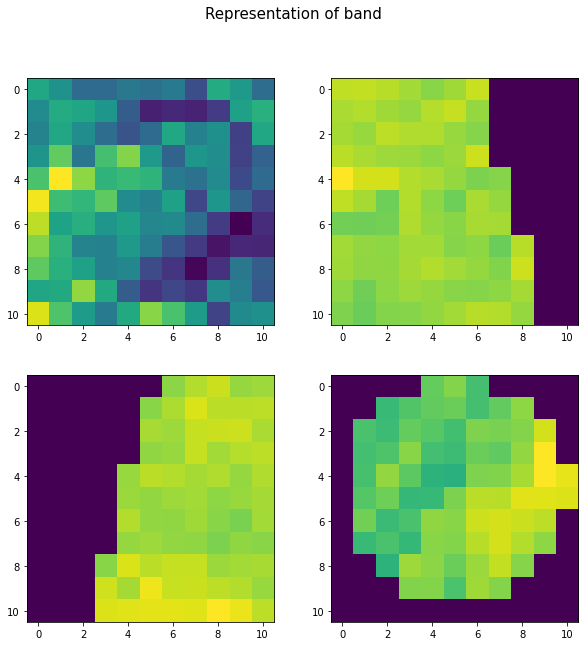

In [66]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

axs[0, 0].imshow(train_data_single_batch['image'][0][0, :, :])
axs[0, 1].imshow(train_data_single_batch['image'][1][0, :, :])

axs[1, 0].imshow(train_data_single_batch['image'][2][0, :, :])
axs[1, 1].imshow(train_data_single_batch['image'][3][0, :, :])

plt.suptitle(f'Representation of band', fontsize=15)
plt.show()

In [67]:
train_data_single_batch['image'].to(device, dtype=torch.float).shape

torch.Size([12, 150, 11, 11])

In [68]:
output = model(train_data_single_batch['image'].to(device, dtype=torch.float))

In [69]:
output.shape

torch.Size([12, 1])

In [70]:
output

tensor([[-0.0857],
        [-0.2041],
        [ 0.8271],
        [-0.0197],
        [ 0.3517],
        [ 0.7864],
        [ 0.3703],
        [ 2.5883],
        [-0.2805],
        [ 1.0211],
        [ 0.9274],
        [-1.8998]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [71]:
stacked_gt = train_data_single_batch['P'].unsqueeze(dim=0).permute(1, 0).to(device)
stacked_gt

tensor([[-0.6544],
        [ 0.3389],
        [-0.1187],
        [-0.4408],
        [-1.1257],
        [-0.2035],
        [-0.1289],
        [ 0.4440],
        [ 0.2338],
        [-1.4850],
        [-0.8002],
        [-0.6307]], device='cuda:0', dtype=torch.float64)

In [72]:
loss_func(output, stacked_gt)

tensor(1.7367, device='cuda:0', dtype=torch.float64,
       grad_fn=<MseLossBackward0>)

#### Sprawdzenie czy inwersja skalowania działa właściwie

In [73]:
gt_df = pd.read_csv(os.path.join(train_data_directory, 'train_gt.csv'))[
    ['sample_index', 'P', 'K', 'Mg', 'pH']]

In [74]:
train_data_single_batch['sample_index']

tensor([1518, 1050, 1540,  639,  161, 1277,    6, 1135, 1390,  109, 1249, 1460])

In [75]:
gt_df.loc[train_data_single_batch['sample_index'], 'P'].values.reshape(-1, 1)

array([[51. ],
       [80.3],
       [66.8],
       [57.3],
       [37.1],
       [64.3],
       [66.5],
       [83.4],
       [77.2],
       [26.5],
       [46.7],
       [51.7]])

In [77]:
scaler = getattr(train_dataset.dataset, f'scaler_P')
scaler

StandardScaler()

In [78]:
scaler.inverse_transform(stacked_gt.cpu())

array([[51. ],
       [80.3],
       [66.8],
       [57.3],
       [37.1],
       [64.3],
       [66.5],
       [83.4],
       [77.2],
       [26.5],
       [46.7],
       [51.7]])

In [79]:
scaler.inverse_transform(stacked_gt.cpu()) == gt_df.loc[train_data_single_batch['sample_index'], 'P'].values.reshape(-1, 1)

array([[ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True]])

#### Właściwa pętla overfit

In [80]:
img_data_device = train_data_single_batch['image'].to(
    device, dtype=torch.float)
stacked_gt_device = train_data_single_batch['P'].unsqueeze(dim=0).permute(1, 0).to(device, dtype=torch.float)
scaler = getattr(train_dataset.dataset, f'scaler_P')

model = ResNetCNN(False).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01)
loss_func = torch.nn.MSELoss()
model.train()

for epoch in range(301):

    output = model(img_data_device)
    loss = loss_func(output, stacked_gt_device)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    output_cpu = output.detach().cpu().numpy()
    stacked_gt_cpu = stacked_gt_device.cpu().numpy()
    
    output_cpu_inversed = scaler.inverse_transform(output_cpu)
    stacked_gt_cpu_inversed = scaler.inverse_transform(stacked_gt_cpu)

    # Calculate MSE for each class
    mse_inversed = np.mean((stacked_gt_cpu_inversed - output_cpu_inversed) ** 2, axis=0)
    mse = np.mean((stacked_gt_cpu - output_cpu) ** 2, axis=0)

    if epoch % 10 == 0:
        print(f'epoch: {epoch}, loss: {loss.data.cpu().numpy()}, MSE: {mse}, MSE from unscaled values: {mse_inversed}')

epoch: 0, loss: 1.431835412979126, MSE: [1.4318355], MSE from unscaled values: [1245.7395]
epoch: 10, loss: 1.571463942527771, MSE: [1.571464], MSE from unscaled values: [1367.2203]
epoch: 20, loss: 1.2136757373809814, MSE: [1.2136757], MSE from unscaled values: [1055.9338]
epoch: 30, loss: 0.5947855114936829, MSE: [0.59478545], MSE from unscaled values: [517.481]
epoch: 40, loss: 0.14740553498268127, MSE: [0.14740555], MSE from unscaled values: [128.24718]
epoch: 50, loss: 0.0033713807351887226, MSE: [0.00337138], MSE from unscaled values: [2.933201]
epoch: 60, loss: 0.018615132197737694, MSE: [0.01861513], MSE from unscaled values: [16.195734]
epoch: 70, loss: 0.003543171100318432, MSE: [0.00354317], MSE from unscaled values: [3.082659]
epoch: 80, loss: 0.0015994127606973052, MSE: [0.00159941], MSE from unscaled values: [1.3915344]
epoch: 90, loss: 0.00038578128442168236, MSE: [0.00038578], MSE from unscaled values: [0.3356419]
epoch: 100, loss: 0.0003177940670866519, MSE: [0.0003177

### Training Definition

In [16]:
parameter = 'pH'

In [17]:
save_name = "checkpoint_state_dict_ResNet50_15_05_2022_Single_Parameter_Scaled_RandomCrop_{}".format(parameter)
save_name

'checkpoint_state_dict_ResNet50_15_05_2022_Single_Parameter_Scaled_RandomCrop_pH'

In [18]:
model_name = save_name+'.pth'

In [19]:
# save subsets indices to text files
np.array(train_dataset.indices).tofile(os.path.join(saved_models_directory, 'DataSubsets_indices', save_name+'_train_indices.txt'), sep='|')
np.array(validation_dataset.indices).tofile(os.path.join(saved_models_directory, 'DataSubsets_indices', save_name+'_validation_indices.txt'), sep='|')

In [20]:
model = ResNetCNN(False).to(device)

In [21]:
wandb.watch(model, log="None", log_freq=20)

[]

In [22]:
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01)

In [23]:
loss_func = torch.nn.MSELoss()

#### Find LR

In [95]:
from torch_lr_finder.lr_finder import TrainDataLoaderIter

In [96]:
class CustomTrainIter(TrainDataLoaderIter):
    def inputs_labels_from_batch(self, batch_data):
        return (torch.as_tensor(batch_data['image'], dtype=torch.float),
                torch.as_tensor(batch_data['P'].unsqueeze(dim=0).permute(1, 0), dtype=torch.float))

In [97]:
lr_finder = LRFinder(model, optimizer, loss_func, device=device)
lr_finder.range_test(CustomTrainIter(train_dataloader),
                     start_lr=0.00001, end_lr=100, num_iter=100)

  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


LR suggestion: steepest gradient
Suggested LR: 6.73E-03


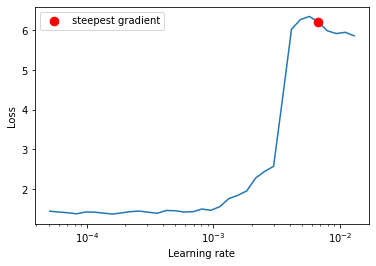

In [98]:
lr_finder.plot()
lr_finder.reset()

In [99]:
6.73E-03

0.00673

### Training

In [24]:
patience_scheduler_overfit = 5
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode='min',
                                                       factor=0.6, patience=patience_scheduler_overfit,
                                                       threshold=0.0001, threshold_mode='abs')

In [25]:
early_stopping = utils.EarlyStopping(patience=(2*patience_scheduler_overfit)+3, verbose=True,
                                     path=os.path.join(saved_models_directory, 'checkpoint_state_dict.pth'))

#### Logging training informations for W&B

In [26]:
config = wandb.config
config.model = 'resnet50'
config.optimizer = 'AdamW'
config.loss_function = 'MSELoss'
config.learning_rate_start = optimizer.param_groups[0]["lr"]
# config.momentum = optimizer.param_groups[0]["momentum"]
config.momentum = None
config.weight_decay = optimizer.param_groups[0]["weight_decay"]
config.scheduler = 'ReduceLROnPlateau'
config.scheduler_factor = 0.6
config.scheduler_patience = 5
config.scheduler_threshold = 0.0001
config.batch_size = BATCH_SIZE
config.notes = 'ResNet50 Parameter {} SCALED Training split:1000, Validation: 732. Scaled predicted variable. Random Crop size 11x11'.format(parameter)
config.parameter = parameter

In [27]:
previous_epochs = 0  # how many epochs have been done previously if resuming

In [28]:
scaler = getattr(train_dataset.dataset, f'scaler_{parameter}')

for epoch in range(previous_epochs, EPOCHS+previous_epochs):
    # TRAINING Part
    model.train()
    train_loss = []
    mse_train_list = []
    mse_inversed_train_list = []

    bar = tqdm(train_dataloader, position=0, leave=False,
               desc=f'epoch {epoch} training data')
    i = 0
    for train_data in bar:  # for each training step
        i += 1
        img_data_device = train_data['image'].to(device, dtype=torch.float)
#         stacked_gt_device = torch.stack((train_data['P'], train_data['K'], train_data['Mg'], train_data['pH'])).transpose(
#             0, 1).to(device, dtype=torch.float)
        stacked_gt_device = train_data[parameter].unsqueeze(dim=0).permute(1, 0).to(device, dtype=torch.float)

        output = model(img_data_device)

        loss = loss_func(output, stacked_gt_device)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss.append(loss)

        output_cpu = output.detach().cpu().numpy()
        stacked_gt_cpu = stacked_gt_device.cpu().numpy()
        
        output_cpu_inversed = scaler.inverse_transform(output_cpu)
        stacked_gt_cpu_inversed = scaler.inverse_transform(stacked_gt_cpu)

        # Calculate MSE for each class
        mse = np.mean((stacked_gt_cpu - output_cpu) ** 2, axis=0)
        mse_inversed = np.mean((stacked_gt_cpu_inversed - output_cpu_inversed) ** 2, axis=0)
        mse_train_list.append(mse)
        mse_inversed_train_list.append(mse_inversed)
        

        if i % 10 == 0:  # log every 10 batches
            train_log_dict = dict()
            train_log_dict['batch_number'] = i
            train_log_dict['epoch'] = epoch
            train_log_dict['train_batch_loss'] = loss
            train_log_dict['train_batch_MSE_{}'.format(parameter)] = mse[0]
            wandb.log(train_log_dict)

    avg_train_loss = torch.stack(train_loss).mean().item()
    avg_train_mse = torch.as_tensor(
        np.array(mse_train_list)).mean(axis=0).numpy().tolist()
    avg_train_mse_inversed = torch.as_tensor(
        np.array(mse_inversed_train_list)).mean(axis=0).numpy().tolist()

    print(
        f'epoch: {epoch}, LR: {optimizer.param_groups[0]["lr"]}, train loss: {avg_train_loss}, train MSE: {avg_train_mse}, train MSE from unscaled values: {avg_train_mse_inversed}')
    wandb.log({'epoch': epoch, 'average_train_loss': avg_train_loss, 'average_train_MSE_{}'.format(parameter): avg_train_mse_inversed[0]})

    # VALIDATION Part
    model.eval()
    val_bar = tqdm(validation_dataloader, position=0,
                   leave=False, desc=f'epoch {epoch} validation data')
    with torch.no_grad():
        val_loss = []
        mse_val_list = []
        mse_inversed_val_list = []
        for val_data in val_bar:
            img_data_device = val_data['image'].to(device, dtype=torch.float)
#             stacked_gt_device = torch.stack((val_data['P'], val_data['K'], val_data['Mg'], val_data['pH'])).transpose(
#                 0, 1).to(device, dtype=torch.float)
            stacked_gt_device =  val_data[parameter].unsqueeze(dim=0).permute(1, 0).to(device, dtype=torch.float)

            output = model(img_data_device)

            loss = loss_func(output, stacked_gt_device)
            val_loss.append(loss)

            output_cpu = output.detach().cpu().numpy()
            stacked_gt_cpu = stacked_gt_device.cpu().numpy()
            
            output_cpu_inversed = scaler.inverse_transform(output_cpu)
            stacked_gt_cpu_inversed = scaler.inverse_transform(stacked_gt_cpu)

            # Calculate MSE for each class
            mse = np.mean((stacked_gt_cpu - output_cpu) ** 2, axis=0)
            mse_val_list.append(mse)
            mse_inversed = np.mean((stacked_gt_cpu_inversed - output_cpu_inversed) ** 2, axis=0)
            mse_inversed_val_list.append(mse_inversed)


        avg_val_loss = torch.stack(val_loss).mean().item()
        avg_val_mse = torch.as_tensor(
            np.array(mse_val_list)).mean(axis=0).numpy().tolist()
        avg_val_mse_inversed = torch.as_tensor(
            np.array(mse_inversed_val_list)).mean(axis=0).numpy().tolist()

        print(f'epoch: {epoch}, validation loss: {avg_val_loss}, validation MSE: {avg_val_mse}, validation MSE from unscaled values: {avg_val_mse_inversed}')
        # using MSE from inversed values in W&B logger to make it compatible with previous runs in W&B
        wandb.log({'epoch': epoch, 'average_val_loss': avg_val_loss, 'average_validation_MSE_{}'.format(parameter): avg_val_mse_inversed[0]}) 

        scheduler.step(avg_val_loss)
        # early_stopping needs the validation loss to check if it has decresed,
        # and if it has, it will make a checkpoint of the current model
        early_stopping(avg_val_loss, model)

        if early_stopping.early_stop:
            print("Early stopping")
            break

epoch 0 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 0, LR: 0.01, train loss: 11.731856346130371, train MSE: [11.731856346130371], train MSE from unscaled values: [0.7944342494010925]


epoch 0 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 0, validation loss: 26.892114639282227, validation MSE: [26.892114639282227], validation MSE from unscaled values: [1.821026086807251]
Validation loss decreased (inf --> 26.892115).  Saving model ...


epoch 1 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 1, LR: 0.01, train loss: 2.1279053688049316, train MSE: [2.1279053688049316], train MSE from unscaled values: [0.14409320056438446]


epoch 1 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 1, validation loss: 2.8372185230255127, validation MSE: [2.837218761444092], validation MSE from unscaled values: [0.1921250969171524]
Validation loss decreased (26.892115 --> 2.837219).  Saving model ...


epoch 2 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 2, LR: 0.01, train loss: 2.5725090503692627, train MSE: [2.5725090503692627], train MSE from unscaled values: [0.17419998347759247]


epoch 2 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 2, validation loss: 8.280257225036621, validation MSE: [8.280257225036621], validation MSE from unscaled values: [0.560705840587616]
EarlyStopping counter: 1 out of 13


epoch 3 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 3, LR: 0.01, train loss: 1.991646409034729, train MSE: [1.991646409034729], train MSE from unscaled values: [0.13486629724502563]


epoch 3 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 3, validation loss: 1.4851443767547607, validation MSE: [1.4851444959640503], validation MSE from unscaled values: [0.10056803375482559]
Validation loss decreased (2.837219 --> 1.485144).  Saving model ...


epoch 4 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 4, LR: 0.01, train loss: 1.3604309558868408, train MSE: [1.3604308366775513], train MSE from unscaled values: [0.09212293475866318]


epoch 4 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 4, validation loss: 2.5278573036193848, validation MSE: [2.527857542037964], validation MSE from unscaled values: [0.17117635905742645]
EarlyStopping counter: 1 out of 13


epoch 5 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 5, LR: 0.01, train loss: 1.42110276222229, train MSE: [1.4211028814315796], train MSE from unscaled values: [0.09623139351606369]


epoch 5 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 5, validation loss: 27.57457733154297, validation MSE: [27.574581146240234], validation MSE from unscaled values: [1.8672399520874023]
EarlyStopping counter: 2 out of 13


epoch 6 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 6, LR: 0.01, train loss: 1.288053274154663, train MSE: [1.2880531549453735], train MSE from unscaled values: [0.08722179383039474]


epoch 6 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 6, validation loss: 6.606473922729492, validation MSE: [6.606473922729492], validation MSE from unscaled values: [0.4473639726638794]
EarlyStopping counter: 3 out of 13


epoch 7 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 7, LR: 0.01, train loss: 1.5687446594238281, train MSE: [1.5687446594238281], train MSE from unscaled values: [0.10622908920049667]


epoch 7 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 7, validation loss: 1.1793512105941772, validation MSE: [1.1793512105941772], validation MSE from unscaled values: [0.07986094057559967]
Validation loss decreased (1.485144 --> 1.179351).  Saving model ...


epoch 8 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 8, LR: 0.01, train loss: 1.3640564680099487, train MSE: [1.3640563488006592], train MSE from unscaled values: [0.09236843138933182]


epoch 8 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 8, validation loss: 1.2566288709640503, validation MSE: [1.2566289901733398], validation MSE from unscaled values: [0.08509387075901031]
EarlyStopping counter: 1 out of 13


epoch 9 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 9, LR: 0.01, train loss: 1.292243242263794, train MSE: [1.292243242263794], train MSE from unscaled values: [0.0875055342912674]


epoch 9 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 9, validation loss: 4.592785358428955, validation MSE: [4.592785358428955], validation MSE from unscaled values: [0.3110049366950989]
EarlyStopping counter: 2 out of 13


epoch 10 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 10, LR: 0.01, train loss: 1.1926822662353516, train MSE: [1.1926822662353516], train MSE from unscaled values: [0.08076366037130356]


epoch 10 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 10, validation loss: 4.364643096923828, validation MSE: [4.364643573760986], validation MSE from unscaled values: [0.29555612802505493]
EarlyStopping counter: 3 out of 13


epoch 11 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 11, LR: 0.01, train loss: 1.4440374374389648, train MSE: [1.4440374374389648], train MSE from unscaled values: [0.09778442233800888]


epoch 11 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 11, validation loss: 2.0500831604003906, validation MSE: [2.0500833988189697], validation MSE from unscaled values: [0.13882341980934143]
EarlyStopping counter: 4 out of 13


epoch 12 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 12, LR: 0.01, train loss: 1.4561794996261597, train MSE: [1.4561794996261597], train MSE from unscaled values: [0.098606638610363]


epoch 12 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 12, validation loss: 0.9338892698287964, validation MSE: [0.9338892698287964], validation MSE from unscaled values: [0.06323923915624619]
Validation loss decreased (1.179351 --> 0.933889).  Saving model ...


epoch 13 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 13, LR: 0.01, train loss: 1.569284439086914, train MSE: [1.5692843198776245], train MSE from unscaled values: [0.10626565665006638]


epoch 13 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 13, validation loss: 18.85955810546875, validation MSE: [18.859556198120117], validation MSE from unscaled values: [1.2770936489105225]
EarlyStopping counter: 1 out of 13


epoch 14 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 14, LR: 0.01, train loss: 1.1656277179718018, train MSE: [1.1656277179718018], train MSE from unscaled values: [0.07893164455890656]


epoch 14 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 14, validation loss: 1.2316123247146606, validation MSE: [1.2316123247146606], validation MSE from unscaled values: [0.08339984714984894]
EarlyStopping counter: 2 out of 13


epoch 15 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 15, LR: 0.01, train loss: 1.1143252849578857, train MSE: [1.1143251657485962], train MSE from unscaled values: [0.07545763999223709]


epoch 15 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 15, validation loss: 0.9199094772338867, validation MSE: [0.9199095964431763], validation MSE from unscaled values: [0.062292587012052536]
Validation loss decreased (0.933889 --> 0.919909).  Saving model ...


epoch 16 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 16, LR: 0.01, train loss: 1.2041314840316772, train MSE: [1.2041314840316772], train MSE from unscaled values: [0.08153896778821945]


epoch 16 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 16, validation loss: 1.0473566055297852, validation MSE: [1.0473566055297852], validation MSE from unscaled values: [0.07092279940843582]
EarlyStopping counter: 1 out of 13


epoch 17 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 17, LR: 0.01, train loss: 0.9814625382423401, train MSE: [0.9814625978469849], train MSE from unscaled values: [0.06646070629358292]


epoch 17 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 17, validation loss: 2.725996255874634, validation MSE: [2.725996494293213], validation MSE from unscaled values: [0.18459351360797882]
EarlyStopping counter: 2 out of 13


epoch 18 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 18, LR: 0.01, train loss: 1.1100867986679077, train MSE: [1.1100869178771973], train MSE from unscaled values: [0.07517062872648239]


epoch 18 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 18, validation loss: 24.128429412841797, validation MSE: [24.128429412841797], validation MSE from unscaled values: [1.633880615234375]
EarlyStopping counter: 3 out of 13


epoch 19 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 19, LR: 0.01, train loss: 0.9853761792182922, train MSE: [0.9853761196136475], train MSE from unscaled values: [0.0667257234454155]


epoch 19 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 19, validation loss: 1.188305377960205, validation MSE: [1.188305377960205], validation MSE from unscaled values: [0.08046726882457733]
EarlyStopping counter: 4 out of 13


epoch 20 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 20, LR: 0.01, train loss: 1.1879631280899048, train MSE: [1.1879632472991943], train MSE from unscaled values: [0.0804441049695015]


epoch 20 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 20, validation loss: 6.731813430786133, validation MSE: [6.731813907623291], validation MSE from unscaled values: [0.45585137605667114]
EarlyStopping counter: 5 out of 13


epoch 21 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 21, LR: 0.01, train loss: 1.0230075120925903, train MSE: [1.0230075120925903], train MSE from unscaled values: [0.06927396357059479]


epoch 21 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 21, validation loss: 6.272533416748047, validation MSE: [6.272533416748047], validation MSE from unscaled values: [0.42475080490112305]
EarlyStopping counter: 6 out of 13


epoch 22 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 22, LR: 0.006, train loss: 0.9740614891052246, train MSE: [0.9740614295005798], train MSE from unscaled values: [0.06595954298973083]


epoch 22 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 22, validation loss: 4.948940277099609, validation MSE: [4.948941230773926], validation MSE from unscaled values: [0.33512240648269653]
EarlyStopping counter: 7 out of 13


epoch 23 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 23, LR: 0.006, train loss: 0.9239938259124756, train MSE: [0.9239937663078308], train MSE from unscaled values: [0.06256915628910065]


epoch 23 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 23, validation loss: 2.131762742996216, validation MSE: [2.131762742996216], validation MSE from unscaled values: [0.1443544328212738]
EarlyStopping counter: 8 out of 13


epoch 24 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 24, LR: 0.006, train loss: 0.9195982813835144, train MSE: [0.9195982217788696], train MSE from unscaled values: [0.06227151304483414]


epoch 24 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 24, validation loss: 4.710809230804443, validation MSE: [4.710809230804443], validation MSE from unscaled values: [0.3189971148967743]
EarlyStopping counter: 9 out of 13


epoch 25 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 25, LR: 0.006, train loss: 0.996158242225647, train MSE: [0.9961583018302917], train MSE from unscaled values: [0.06745585799217224]


epoch 25 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 25, validation loss: 1.6813243627548218, validation MSE: [1.6813244819641113], validation MSE from unscaled values: [0.11385254561901093]
EarlyStopping counter: 10 out of 13


epoch 26 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 26, LR: 0.006, train loss: 0.9132728576660156, train MSE: [0.9132729768753052], train MSE from unscaled values: [0.06184318661689758]


epoch 26 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 26, validation loss: 2.015887498855591, validation MSE: [2.015887498855591], validation MSE from unscaled values: [0.1365078091621399]
EarlyStopping counter: 11 out of 13


epoch 27 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 27, LR: 0.006, train loss: 0.930636465549469, train MSE: [0.930636465549469], train MSE from unscaled values: [0.06301897019147873]


epoch 27 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 27, validation loss: 3.8342466354370117, validation MSE: [3.8342466354370117], validation MSE from unscaled values: [0.25963979959487915]
EarlyStopping counter: 12 out of 13


epoch 28 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 28, LR: 0.0036, train loss: 0.9194894433021545, train MSE: [0.9194893836975098], train MSE from unscaled values: [0.06226413697004318]


epoch 28 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 28, validation loss: 1.1661388874053955, validation MSE: [1.1661388874053955], validation MSE from unscaled values: [0.07896625250577927]
EarlyStopping counter: 13 out of 13
Early stopping


#### Saving model state dict and loading

In [29]:
torch.save(model.state_dict(), os.path.join(
    saved_models_directory, model_name+f'_EPOCHS_{epoch}.pth'))

In [30]:
# rename checkpoint.pth
! mv ../../saved_models/checkpoint_state_dict.pth ../../saved_models/checkpoint_state_dict_ResNet50_15_05_2022_Single_Parameter_Scaled_RandomCrop_pH.pth

In [31]:
# load saved model
modelLoad = ResNetCNN(False)
modelLoad.load_state_dict(torch.load(os.path.join(
    saved_models_directory, 'checkpoint_state_dict_ResNet50_15_05_2022_Single_Parameter_Scaled_RandomCrop_pH.pth')))

<All keys matched successfully>

In [32]:
modelLoad = modelLoad.to(device)